# Mineração de Dados

## Análise de BOs de Fortaleza e Clusterização Usando o Algoritmo DBScan

A atividade consiste basicamente em analizar os dados relativos a BOs registrados em Fortaleza em um determinado período e obter informações dos mesmos.
Neste documento, são apresentados algumas técnicas que visam responder itens como os abaixo:
    
    1 - Faça um breve análise exploratória do dataset
        1.1 - Verifique a quantidade de ocorrências por cada tipo  
        1.2 - Plot as ocorrências no espaço, usando latitude e longitude
        1.3 - Aplique uma outra análise que achar interessante
        1.4- Plot a distribução das distâncias entre os pontos. Utilize a distância para dados geolocalizados https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

    2 - Para identificar regiões com alta taxas de crime, aplique os algoritmos de clusterização vistos DBSCAN https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html e clustering hieráquico https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering sobre o dataset
        2.1 - Considere como atributos latitude e longitude das ocorrências. 
        2.2 - Varie os parâmetros de cada um dos algoritmos em pelo menos 3 valores diferentes. 

    3 - Analise os resultados
        3.1 - Plot os dados, use uma cor diferente por cluster.

### Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import mplleaflet as mpl
import seaborn as sns
%matplotlib inline

In [2]:
#data = pd.read_csv('Cluster-Crime-Maio.gzip', compression='gzip')
data = pd.read_csv('Cluster-Crime-Maio.csv', na_values='nulo')

In [3]:
data.head()

,ID,FONTE,FLAGRANTE,NATUREZA DA OCORRÊNCIA,HISTÓRICO DA OCORRÊNCIA,LOCAL:,BAIRRO,SUSPEITO:,VEÍCULO:,VÍTIMA:,...,ARMA APREENDIDA:,MATERIAL APREENDIDO:,PLACA:,VÍTIMAS LESIONADAS:,SUSPEITOS:,HORA,MINUTO,DATA,LATITUDE,LONGITUDE
0,1,CIOPS,NÃO,MORTE - A BALA,"LOCAL: RUA CODO, JANGURUSSU. VÍTIMA: TIAGO S.P...","RUA CODO, JANGURUSSU",JANGURUSSU,NaN,NaN,TIAGO S,...,NaN,NaN,NaN,NaN,NÃO IDENTIFICADOS,10,37,01/05/17,-3.850046,-38.522390
1,2,CIOPS,NÃO,MORTE A BALA,"LOCAL: AV. LESTE OESTE, PIRAMBU. VÍTIMA: RAFAE...","AV. LESTE OESTE, PIRAMBU",PIRAMBU,NaN,NaN,RAFAEL RS,...,NaN,NaN,NaN,NaN,NÃO IDENTIFICADOS,11,50,01/05/17,-3.712388,-38.553322
2,3,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA TAILANDIA, GENIBAÚ. VÍTIMA: ISRAEL ...","RUA TAILANDIA, GENIBAU",GENIBAU,NaN,NaN,ISRAEL RA,...,NaN,NaN,NaN,NaN,NÃO IDENTIFICADOS,13,53,01/05/17,-3.758621,-38.604318
3,4,CIOPS,NÃO,MORTE A BALA,LOCAL: RUA DR JOAQUIM FROTA SAPIRANGA COITÉ. V...,RUA DR JOAQUIM FROTA SAPIRANGA COITE,RUA DR JOAQUIM FROTA SAPIRANGA COITE,NaN,NaN,DAVI M,...,NaN,NaN,NaN,NaN,NÃO IDENTIFICADOS,15,14,01/05/17,-3.801281,-38.472957
4,5,CIOPS,NÃO,MORTE A BALA,"LOCAL: RUA CARNAUBAL, ALVARO WEYNE. VÍTIMA: DI...","RUA CARNAUBAL, ALVARO WEYNE",ALVARO WEYNE,NaN,NaN,DIEGO T,...,NaN,NaN,NaN,NaN,NÃO IDENTIFICADOS,17,42,01/05/17,-3.722553,-38.582816


In [4]:
data = data.set_index('ID')

In [5]:
data.isna().sum()

FONTE                        0
FLAGRANTE                    0
NATUREZA DA OCORRÊNCIA       0
HISTÓRICO DA OCORRÊNCIA      0
LOCAL:                       0
BAIRRO                       0
SUSPEITO:                  390
VEÍCULO:                   349
VÍTIMA:                    424
VÍTIMAS:                   558
VÍTIMA FATAL:              566
ARMA APREENDIDA:           509
MATERIAL APREENDIDO:       540
PLACA:                     523
VÍTIMAS LESIONADAS:        566
SUSPEITOS:                 432
HORA                         0
MINUTO                       0
DATA                         0
LATITUDE                     0
LONGITUDE                    0
dtype: int64

In [6]:
data.shape

(567, 21)

In [7]:
data = data.drop(['SUSPEITO:', 'VEÍCULO:', 'VÍTIMAS:', 'VÍTIMA FATAL:', 'ARMA APREENDIDA:', 'MATERIAL APREENDIDO:', 'PLACA:', 'VÍTIMAS LESIONADAS:', 'SUSPEITOS:'], axis=1)

##### 1 - Faça uma breve análise exploratória do dataset

###### 1.1 - Mostrando a quantidade de ocorrências por cada tipo de ocorrência registrado

In [8]:
count = data['NATUREZA DA OCORRÊNCIA'].value_counts()
count

VEICULO LOCALIZADO                                                                      222
MORTE A BALA                                                                             97
PORTE ILEGAL DE ARMA                                                                     45
TRAFICO DE ENTORPECENTES                                                                 25
ROUBO A PESSOA                                                                           13
PESSOA EM SITUACAO SUSPEITA                                                               6
VEICULOS LOCALIZADOS                                                                      5
TRAFICO DE ENTORPECENTES (ATO INFRACIONAL)                                                4
PORTE ILEGAL DE ARMA  (ATO INFRACIONAL)                                                   4
PORTE ILEGAL DE ARMA (ATO INFRACIONAL)                                                    4
CUMPRIMENTO DE MANDADO JUDICIAL                                                 

In [9]:
count.index

Index(['VEICULO LOCALIZADO', 'MORTE A BALA', 'PORTE ILEGAL DE ARMA',
       'TRAFICO DE ENTORPECENTES', 'ROUBO A PESSOA',
       'PESSOA EM SITUACAO SUSPEITA', 'VEICULOS LOCALIZADOS',
       'TRAFICO DE ENTORPECENTES (ATO INFRACIONAL)',
       'PORTE ILEGAL DE ARMA  (ATO INFRACIONAL)',
       'PORTE ILEGAL DE ARMA (ATO INFRACIONAL)',
       ...
       'MORTE A BALA LESÕES CORPORAIS A BALA', 'FURTO A ESTABELECIMENTO',
       'PORTE ILEGAL DE', 'TRAFICO ENTORPECENTES', 'TRAFICO DE ENTORPENTE',
       'FURTO A ESTABELECIMENTO / APREENSAO DE ARMAS (ATO INFRACIONAL / FLAGRANTE)',
       'ROUBO A PESSOA PORTE ILEGAL DE ARMA',
       'ROUBO DE VEICULO /PORTE ILEGAL DE ARMA',
       'ROUBO DE VEICULO / ROUBO A PESSOA (ATO INFRACIONAL)',
       'TENTATIVA ROUBO(ATO INFRACIONAL )'],
      dtype='object', length=122)

###### 1.2 - Plot as ocorrências no espaço, usando latitude e longitude

In [10]:
data.plot(x='LONGITUDE', y='LATITUDE', kind='scatter')
mpl.display()

/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


###### 1.4- Plot a distribução das distâncias entre os pontos. Utilize a distância para dados geolocalizados https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html 

In [11]:
from sklearn.metrics.pairwise import haversine_distances

x = data[['LATITUDE', 'LONGITUDE']]

result = haversine_distances(x, x)
final_result = result * 6371000/1000  # multiply by Earth radius to get kilometers

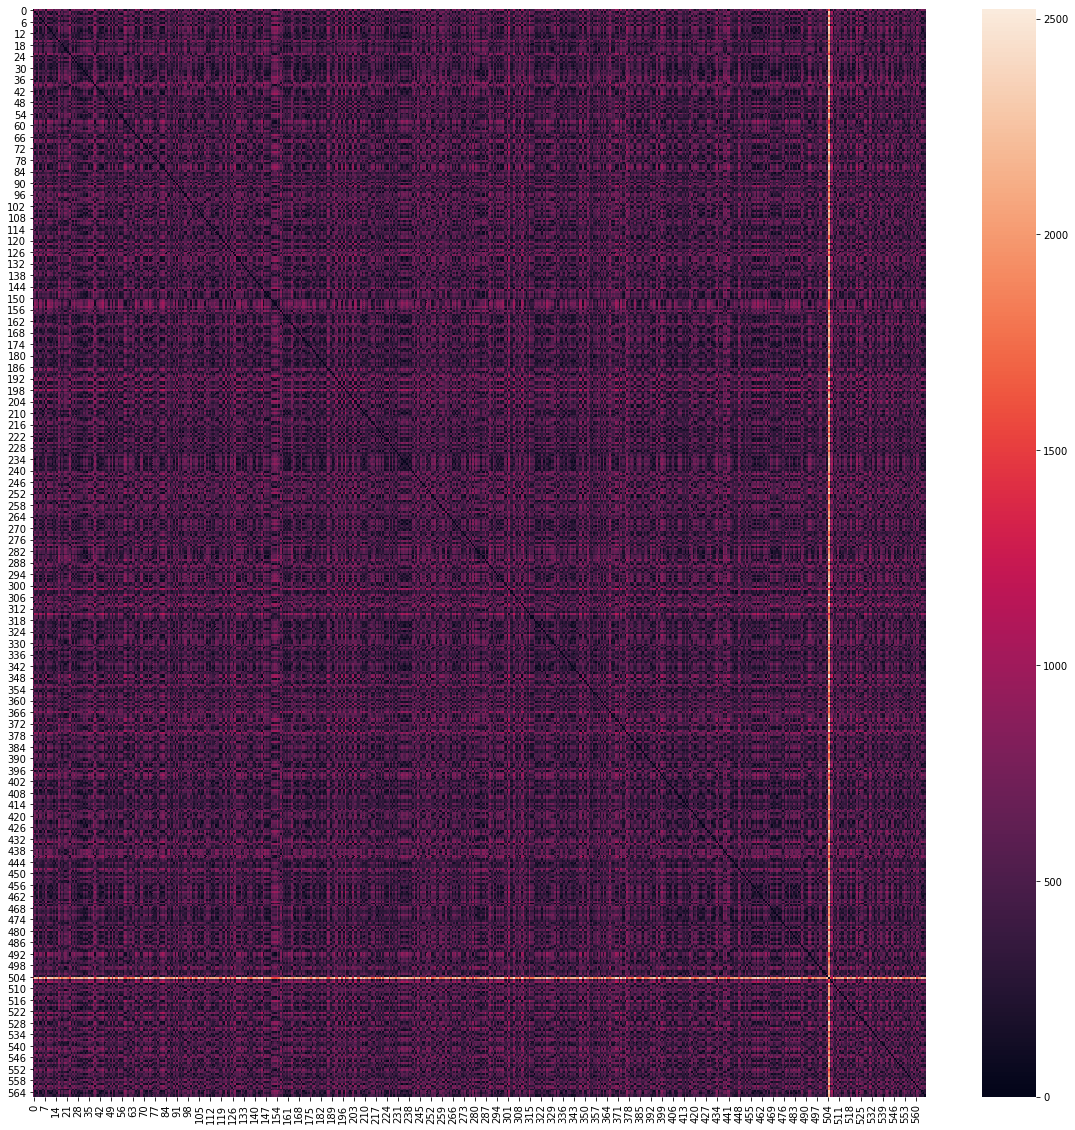

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(final_result, )

### Clusterização usando DBScan

In [13]:
X = data[['LATITUDE', 'LONGITUDE']]
# x = data['LATITUDE']
# y = data['LONGITUDE']

In [14]:
X = StandardScaler().fit_transform(X)

In [15]:
DBScan = DBSCAN(eps=3, min_samples=2)
model = DBScan.fit(X)

In [16]:
labels = model.labels_

In [17]:
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[DBScan.core_sample_indices_] = True
print(core_samples)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [18]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

1

In [19]:
metrics.silhouette_score(X,labels)

0.771044722322336